<a href="https://colab.research.google.com/github/wfus/compressed-sensing/blob/master/Compressed_Sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressed Sensing Project

We will be implementing compressed sensing. We will be using CIFAR-100 as a good dataset for images. The dataset can be downloaded [here.](https://www.cs.toronto.edu/~kriz/cifar.html)

## Data Loading

Here is some code that loads in the images in standard numpy format. The format given in CIFAR-100 is with the channel, most likely $C \times W \times H$, while we want it $H \times W \times C$ to display it using numpy and matplotlib, and for when we feed it into our neural network.

In [0]:
import numpy as np
import scipy
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
%%bash
wget -nc https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
tar xvf cifar-100-python.tar.gz

In [0]:
def unpickle(file):
    if sys.version_info >= (3,0):
        import pickle
        with open(file, 'rb') as fo:
            d = pickle.load(fo, encoding='bytes')
        return d
    else:
        import cPickle
        with open(file, 'rb') as fo:
            d = cPickle.load(fo)
        return d

def cifar_to_image(data):
    test_image = data.reshape(3, 32, 32)
    test_image = test_image.swapaxes(0, 2)
    test_image = test_image.swapaxes(0, 1)
    return test_image

train_data = unpickle('cifar-100-python/train')
test_data = unpickle('cifar-100-python/test')
images = train_data[b'data']
labels = train_data[b'fine_labels']
test_images = test_data[b'data']
test_labels = test_data[b'fine_labels']

In [0]:
print('Number of images in training set: %d' % len(images))
print('Number of images in testing set: %d' % len(test_images))

In [0]:
def plot_random_image(test1):
    plt.grid(False)
    plt.imshow(test1)
    plt.show()
    
def get_random_image():
    rand_index = np.random.choice(range(len(images)))
    print('Chose index %d from training set' % rand_index)
    print('Label: %d' % labels[rand_index])
    test1 = cifar_to_image(images[rand_index])
    return test1

In [0]:
test = get_random_image()
plot_random_image(test)

## Turning the Image Sparse

Compressive sensing works by converting our image into a domain where it is sparse. This is very similar to how we transform into frequency space and quantize in JPEG and other popular image encoding methods. This will apply the DCT transform and some quantization to make our values `uint8`. This is the way most images are encoded before sending it through a network channel.



### DCT

The DCT can be done in `scipy`, [here](http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/) is a nice link as a tutorial. That link applies to the DCT on the full image, but we want to experiment using the DCT on $8 \times 8$ blocks just like JPEG first. Some code for that is available [here](https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html) as a nice Jupyter notebook from Berkeley.

#### Full Image DCT

We'll first try the DCT matrix on the full image and see what happens. We can also see 

In [0]:
import scipy
import numpy as np

In [0]:
from scipy import fftpack as fft

def dct_full_2D(image):
    return fft.dct(fft.dct(image.T, norm='ortho').T, norm='ortho')

def idct_full_2D(coefficients):
    return fft.idct(fft.idct(coefficients.T, norm='ortho').T, norm='ortho')

def image_to_dct(image):
    return np.array(dct_full_2D(image), dtype=np.int32)

def dct_to_image(dctmatrix):
    return idct_full_2D(dctmatrix).clip(0, 255).astype(np.uint8)
    

In [0]:
dct_test = get_random_image()
plot_random_image(dct_test)

In [0]:
dct_test_converted = dct_full_2D(dct_test)

In [0]:
N_COLOR_CHANNELS = 3
for chan in range(N_COLOR_CHANNELS):
    plt.subplot(1, 3, chan + 1)
    plt.imshow(dct_test_converted[:, :, chan])
    
dct_test_int = np.array(dct_test_converted, dtype=np.int32)
print('Sparsity of DCT: ', np.sum(dct_test_int == 0) / float(dct_test_int.size))

We see that this is indeed a pretty sparse representation, once we take the floor of everything to make the coefficients integers. Let's turn the image back once we have done this step to see our recovered image (rounding the DCT coefficients lose some information)

In [0]:
plot_random_image(dct_to_image(dct_test_int))

## Retrieval with Data-driven Approaches

Let's first try the naive approach. The naive approach we don't expect will work well at all.

In the CIFAR case, note that the image values have the support $\mathbb{R}^{32 \times 32 \times 3}$. However, we are assuming that the domain of natural images is actually much much smaller. Through training with the data, we should be able to try to train a blackbox to retrieve images from undersampled measurements.

### Making the Sensing Matrix

First, let's flatten our DCT coefficients, so our original signal in a sparse space is $\mathbf{x} \in \mathbb{R}^{3072}$. Then, the setup of our problem will be mapping signals from $\mathbb{R}^{N} \to \mathbb{R}^{M}$. For now, we will assume that the sensing matrix is distributed randomly.

$$N = 3072$$
$$M = \mathsf{[500, 1000, 1500, 2000]}$$
$$x \in \mathbb{R}^N$$
$$A \in \mathbb{R}^{N \times M}$$
$$A_{i, j} \sim \mathcal{N}(0, 1)$$
$$y = Ax$$

We will implement our sensing matrix as a fully-connected layer in our neural network. We will initialize it with a Gaussian, which should give us what we want.

In [0]:
import torch
import torch.distributions as ds
from torch import nn
from torch.utils import data as utils
import torch.nn.functional as F

In [0]:
N = 3072
M = 2000
test_x = ds.Normal(torch.zeros(N), torch.ones(N)).sample()
A = ds.Normal(torch.zeros((M, N)), torch.ones((M, N))).sample()

In [0]:
test_y = torch.matmul(A, test_x)
test_y.shape

### Preprocessing our Data

Our FCN should be mapping the $y$ back to the sparse $x$. Therefore, we will have to get our images, sparsify them, and those will be $x$. The $y$ we feed in to the neural network will be $Ax$. It's kind of confusing because the variables are swapped, but:

```
train_X: undersampled measurements y = Ax
train_y: original sparse flattened DCT of image, x
```

We will have to preprocess our CIFAR images first.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: %s' % str(device))

In [0]:
def cifar_to_sparse(image):
    image = cifar_to_image(image)
    image = image_to_dct(image)
    return image.flatten()

sparse_X = torch.tensor([cifar_to_sparse(im) for im in images]).float()
test_sparse_X = torch.tensor([cifar_to_sparse(im) for im in test_images]).float()

In [0]:
train_X = torch.matmul(sparse_X, A.t()).to(device)
train_y = sparse_X.to(device)

test_X = torch.matmul(test_sparse_X, A.t()).to(device)
test_y = test_sparse_X.to(device)

train_data = utils.TensorDataset(train_X, train_y)
dataloader = utils.DataLoader(train_data, batch_size=64, shuffle=True)

In [0]:
class JohnNet(nn.Module):
    """A NN that definitely won't work, lmao, Test our dataloader."""
    def __init__(self, N, M, A):
        super(JohnNet, self).__init__()
        self.fc1 = nn.Linear(M, 100)
        self.fc2 = nn.Linear(100, N)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [0]:
net = JohnNet(N, M, A).to(device)

In [0]:
import tqdm
epochs = 1000
epoch_queue = tqdm.tqdm(range(epochs))
for epoch in epoch_queue:
    for index, batch in enumerate(dataloader):
        X, y = batch
        optimizer = torch.optim.Adam(net.parameters())
        criterion = nn.MSELoss()
    
        optimizer.zero_grad()
        y_hat = net(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    
    y_hat = net(test_X)
    test_loss = criterion(y_hat, test_y)
    epoch_queue.set_description("Test Loss: %d" % test_loss)

Test Loss: 5792: 100%|██████████| 1000/1000 [16:00<00:00,  1.05it/s]


Now let's look at our predicted images to see if they even look reasonable at all. It probably won't TBQH.

In [0]:
import random

def plot_naive_training():
    rand_index = random.randint(0, len(train_X) - 1)
    test_x_image = train_X[rand_index]
    test_y_image = train_y[rand_index]
    pred_sparse = net(test_x_image)
    pred_image = dct_to_image(pred_sparse.reshape(32, 32, 3).cpu().detach().numpy())
    real_image = dct_to_image(test_y_image.reshape(32, 32, 3).cpu().detach().numpy())

    plt.subplot(1, 2, 1)
    plt.imshow(pred_image)
    plt.subplot(1, 2, 2)
    plt.imshow(real_image)
    plt.show()
    
def plot_naive_testing():
    rand_index = random.randint(0, len(test_X) - 1)
    test_x_image = test_X[rand_index]
    test_y_image = test_y[rand_index]
    pred_sparse = net(test_x_image)
    pred_image = dct_to_image(pred_sparse.reshape(32, 32, 3).cpu().detach().numpy())
    real_image = dct_to_image(test_y_image.reshape(32, 32, 3).cpu().detach().numpy())

    plt.subplot(1, 2, 1)
    plt.imshow(pred_image)
    plt.subplot(1, 2, 2)
    plt.imshow(real_image)
    plt.show()

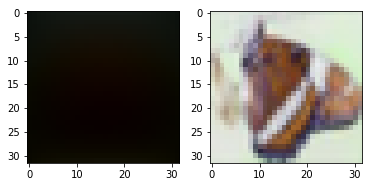

In [0]:
plot_naive_testing()

In [0]:
sensing_fc = nn.Linear(N, M, bias=False)  # If we do decide to actually optimize for the sensing layer.

In [0]:
test_x

tensor([-1.5866,  0.2789, -0.9628,  ..., -0.1109, -0.9543,  0.8594])

In [0]:
nn.init.normal_(sensing_fc.weight, 0, 1)

Parameter containing:
tensor([[ 0.0805, -0.1097,  0.7224,  ...,  2.1265,  0.5065,  0.0935],
        [-0.0101, -0.7676,  0.0477,  ..., -0.3958,  0.2011,  0.2303],
        [ 0.2383, -1.0049,  0.2266,  ...,  0.5397,  1.0106,  0.6275],
        ...,
        [ 0.1016, -0.7452,  0.9516,  ..., -0.2994,  1.3512,  0.5771],
        [ 0.4895,  2.0024, -0.4702,  ...,  1.0088,  0.6933, -0.1347],
        [ 0.7317, -0.1853, -1.8950,  ..., -1.2375,  0.3239,  0.0671]],
       requires_grad=True)

In [0]:
image


NameError: ignored

In [0]:
image

NameError: ignored

## Another approach - using the Adjoint

What if we feed into our neural network the adjoint without doing the DCT first? Again, we'll essentially be using a linear layer at the beginning and performing retrieval. This is very similar to the paper [Mousavi and baraniuk - Learning to invert: Signal Recovery via Deep Convolutional Networks.](https://arxiv.org/abs/1701.03891)

Now, we're going to undersample in a weirder way. We will first have images that are $32 \times 32 \times 3$. We are then going to flatten, downsample to dimension $2700$ to get our resultant $y$. Then, we will calculate $\tilde{x} = A^\top y$ and feed $\tilde{x}$ into our FCN. Lets do it!

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: %s' % str(device))

image_X = torch.tensor([cifar_to_image(im) for im in images]).float().to(device)
test_image_X = torch.tensor([cifar_to_image(im) for im in test_images]).float().to(device)

In [0]:
print(image_X.shape)
print(test_image_X.shape)

image_X.view(image_X.shape[0], -1).shape

In [0]:
# For training purposes, we're essentially multiplying by A^T A
ATA = A.t().mm(A).to(device)

# Flatten, apply our sensing matrix, and multiply by adjoint.
train_X = image_X.view(image_X.shape[0], -1).mm(ATA).view(image_X.shape)
test_X = test_image_X.view(test_image_X.shape[0], -1).mm(ATA).view(test_image_X.shape)

train_y = image_X
test_y = test_image_X

In [0]:
def plot_train_test(index):
    train_signal = train_X[index].cpu().numpy().astype(np.uint8)
    test_signal = train_y[index].cpu().numpy().astype(np.uint8)
    
    plt.subplot(1, 2, 1)
    plt.imshow(train_signal)
    plt.subplot(1, 2, 2)
    plt.imshow(test_signal)
    plt.show()

In [0]:
plot_train_test(1)

In [0]:
plot_train_test(2)